In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchtext
import os
from pathlib import Path

In [2]:
PATH = Path('./data')
os.listdir(PATH)

['sample_submission.csv',
 'submission.csv',
 'test.csv',
 'test_clean.csv',
 'train.csv',
 'train_clean.csv']

In [3]:
TEXT = torchtext.data.Field(tokenize="spacy")
LABEL = torchtext.data.LabelField(dtype = torch.long)

dataset = torchtext.data.TabularDataset(
    path = PATH / 'train_clean.csv',
    format = 'CSV',
    fields = [('text', TEXT), ('target', LABEL)],
    skip_header = True
)

len(dataset)

7613

In [4]:
ix = 0
print(vars(dataset.examples[ix]))

{'text': ['Our', 'Deeds', 'are', 'the', 'Reason', 'of', 'this', '#', 'earthquake', 'May', 'ALLAH', 'Forgive', 'us', 'all'], 'target': '1'}


In [5]:
train_dataset, valid_dataset = dataset.split(
    split_ratio=0.6,
    stratified=True,
    strata_field='target'
)

len(train_dataset), len(valid_dataset)

(4568, 3045)

In [6]:
MAX_VOCAB_SIZE = 10000

TEXT.build_vocab(train_dataset, max_size=MAX_VOCAB_SIZE)
LABEL.build_vocab(train_dataset)

In [7]:
len(TEXT.vocab), len(LABEL.vocab)

(10002, 2)

In [8]:
TEXT.vocab.itos[:10]

['<unk>', '<pad>', '#', '?', '.', 'the', ':', 'a', 'to', 'in']

In [9]:
TEXT.vocab.freqs.most_common(10)

[('#', 2047),
 ('?', 1905),
 ('.', 1735),
 ('the', 1587),
 (':', 1146),
 ('a', 1145),
 ('to', 1102),
 ('in', 1078),
 ('of', 1027),
 ('I', 967)]

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"

dataloader = {
    'train': torchtext.data.BucketIterator(train_dataset, batch_size=64, shuffle=True, device=device),
    'val': torchtext.data.BucketIterator(valid_dataset, batch_size=100, device=device)
}

In [11]:
class RNN(torch.nn.Module):
    def __init__(self, input_dim, embedding_dim=128, hidden_size=128, num_layers=2, n_outputs=2):
        super().__init__()
        self.embedding = torch.nn.Embedding(input_dim, embedding_dim)
        self.rnn = torch.nn.RNN(
            input_size=embedding_dim, 
            hidden_size=hidden_size, 
            num_layers=num_layers)
        self.fc = torch.nn.Linear(hidden_size, n_outputs)
        
    def forward(self, text):
        embedded = self.embedding(text)
        output, _ = self.rnn(embedded)
        # [l, bs, h]
        return self.fc(output[-1,:,:].squeeze(0))

In [12]:
model = RNN(input_dim=len(TEXT.vocab))
output = model(torch.randint(0, len(TEXT.vocab), (100, 64)))
output.shape

torch.Size([64, 2])

In [13]:
import sklearn.metrics as m

def fit(model, dataloader, epochs=10, lr=1e-3):
    model.to(device)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr)

    hist = {'loss': [], 'f1': [], 'val_loss': [], 'val_f1': []}
    best_f1 = 0.
    for e in range(1, epochs+1):
        model.train()
        l, f1s = [], []
        for batch in dataloader['train']:
            optimizer.zero_grad()
            y_pred = model(batch.text)
            loss = criterion(y_pred, batch.target)
            l.append(loss.item())
            loss.backward()
            optimizer.step()
            y_pred = torch.argmax(y_pred, axis=1)
            f1s.append(m.f1_score(batch.target.cpu(), y_pred.cpu()))
        hist['loss'].append(np.mean(l))
        hist['f1'].append(np.mean(f1s))
        model.eval()
        l, acc, f1s = [], [], []
        with torch.no_grad():
            for batch in dataloader['val']:
                y_pred = model(batch.text)
                loss = criterion(y_pred, batch.target)
                l.append(loss.item())          
                y_pred = torch.argmax(y_pred, axis=1)
                f1s.append(m.f1_score(batch.target.cpu(), y_pred.cpu()))
        hist['val_loss'].append(np.mean(l))
        hist['val_f1'].append(np.mean(f1s))
        if hist["val_f1"][-1] > best_f1:
            best_f1 = hist["val_f1"][-1]
            torch.save(model.state_dict(), 'ckpt.pt')
        print(f'Epoch {e}/{epochs} loss {hist["loss"][-1]:.5f} f1 {hist["f1"][-1]:.5f} val_loss {hist["val_loss"][-1]:.5f} val_f1 {hist["val_f1"][-1]:.5f}')
    model.load_state_dict(torch.load('ckpt.pt'))
    return hist

In [14]:
model = RNN(input_dim=len(TEXT.vocab))
hist = fit(model, dataloader)

Epoch 1/10 loss 0.69389 f1 0.14905 val_loss 0.68733 val_f1 0.03315
Epoch 2/10 loss 0.68676 f1 0.06236 val_loss 0.68320 val_f1 0.00888
Epoch 3/10 loss 0.68670 f1 0.01269 val_loss 0.68360 val_f1 0.00300
Epoch 4/10 loss 0.68609 f1 0.04089 val_loss 0.68669 val_f1 0.00337
Epoch 5/10 loss 0.68350 f1 0.00979 val_loss 0.68354 val_f1 0.00849
Epoch 6/10 loss 0.68407 f1 0.01988 val_loss 0.68901 val_f1 0.00462
Epoch 7/10 loss 0.68285 f1 0.02454 val_loss 0.68517 val_f1 0.02016
Epoch 8/10 loss 0.68391 f1 0.01981 val_loss 0.68291 val_f1 0.01580
Epoch 9/10 loss 0.68303 f1 0.01877 val_loss 0.68364 val_f1 0.01338
Epoch 10/10 loss 0.68254 f1 0.01771 val_loss 0.68248 val_f1 0.01033


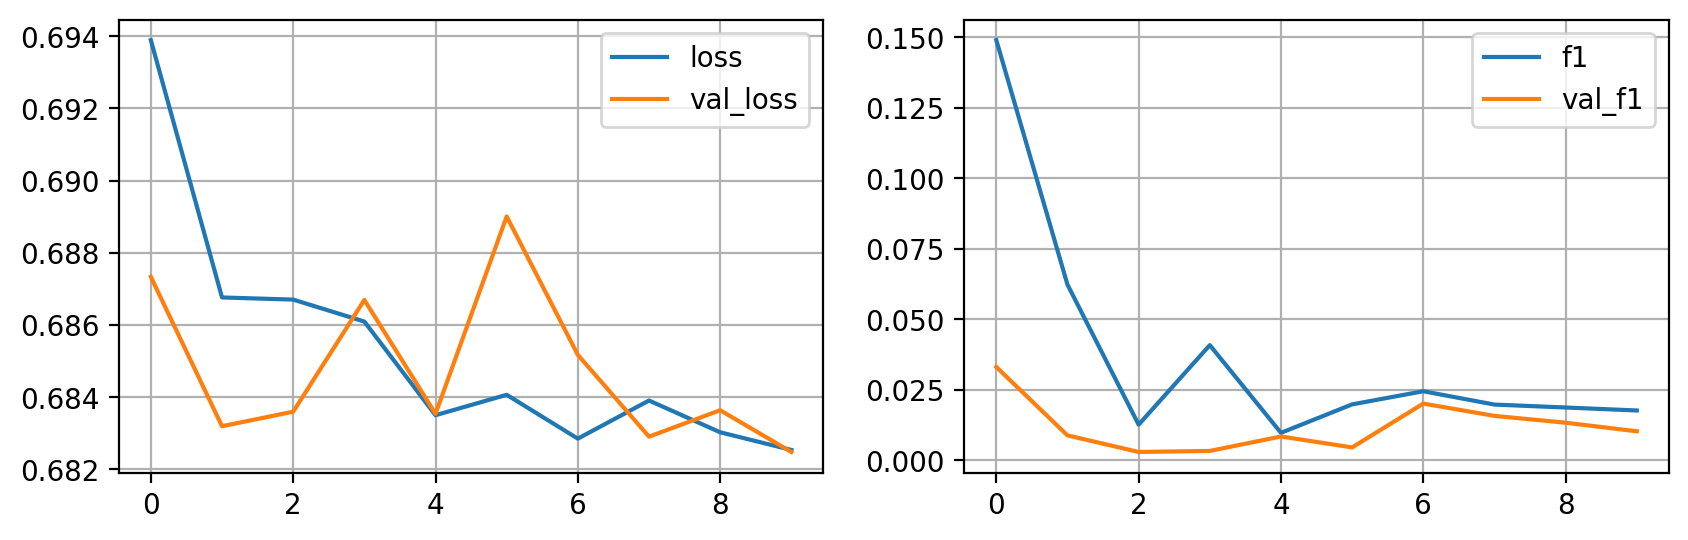

In [15]:
def plot(hist):
    fig = plt.figure(dpi=200,figsize=(10,3))
    ax = plt.subplot(121)
    hist = pd.DataFrame(hist)
    hist[['loss', 'val_loss']].plot(ax=ax, grid=True)
    ax = plt.subplot(122)
    hist[['f1', 'val_f1']].plot(ax=ax, grid=True)
    plt.show()
    
plot(hist)

In [16]:
class LSTM(RNN):
    def __init__(self, input_dim, embedding_dim=128, hidden_size=128, num_layers=2, n_outputs=2, bidirectional=False, dropout=0):
        super().__init__(input_dim, embedding_dim, hidden_size, num_layers, n_outputs)
        self.rnn = torch.nn.LSTM(
            input_size=embedding_dim, 
            hidden_size=hidden_size, 
            num_layers=num_layers,
            bidirectional=bidirectional,
            dropout=dropout
        )
        if bidirectional:
            self.fc = torch.nn.Linear(2*hidden_size, n_outputs)

Epoch 1/10 loss 0.68376 f1 0.00000 val_loss 0.68281 val_f1 0.00000
Epoch 2/10 loss 0.68076 f1 0.00107 val_loss 0.68452 val_f1 0.50265
Epoch 3/10 loss 0.62934 f1 0.51577 val_loss 0.59309 val_f1 0.60541
Epoch 4/10 loss 0.53787 f1 0.67577 val_loss 0.55756 val_f1 0.60691
Epoch 5/10 loss 0.44108 f1 0.75251 val_loss 0.55113 val_f1 0.67068
Epoch 6/10 loss 0.35140 f1 0.82021 val_loss 0.55944 val_f1 0.68356
Epoch 7/10 loss 0.27353 f1 0.87267 val_loss 0.60340 val_f1 0.66709
Epoch 8/10 loss 0.20416 f1 0.91279 val_loss 0.70435 val_f1 0.66590
Epoch 9/10 loss 0.16470 f1 0.93243 val_loss 0.77958 val_f1 0.68192
Epoch 10/10 loss 0.11521 f1 0.95550 val_loss 0.91559 val_f1 0.69745


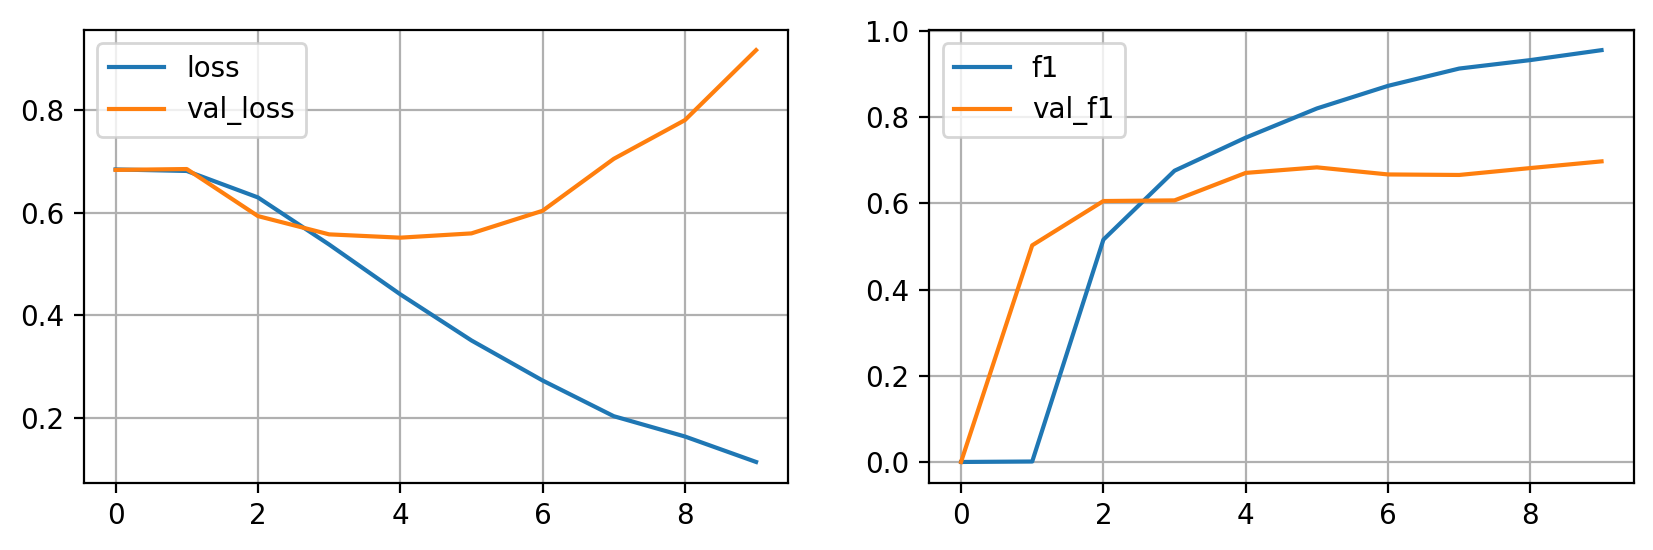

In [17]:
model = LSTM(input_dim=len(TEXT.vocab), bidirectional=False)
hist = fit(model, dataloader)
plot(hist)

In [18]:
test_dataset = torchtext.data.TabularDataset(
    path = PATH / 'test_clean.csv',
    format = 'CSV',
    fields = [('text', TEXT)],
    skip_header = True
)

len(test_dataset)

3263

In [19]:
ix = 3258
print(vars(test_dataset.examples[ix]))

{'text': ['EARTHQUAKE', 'SAFETY', 'LOS', 'ANGELES', '\x89ÛÒ', 'SAFETY', 'FASTENERS', 'XrWn']}


In [20]:
test_dataloader = torchtext.data.BucketIterator(test_dataset, batch_size=64, shuffle=False, device=device)

In [21]:
def predict():
    model.eval()
    preds = torch.tensor([]).to(device)
    with torch.no_grad():
        for batch in test_dataloader:
            y_pred = model(batch.text)        
            y_pred = torch.argmax(y_pred, axis=1)
            preds = torch.cat([preds, y_pred])
    return preds

In [22]:
preds = predict()
preds

tensor([1., 1., 1.,  ..., 1., 1., 1.], device='cuda:0')

In [23]:
submission = pd.read_csv(PATH  / 'sample_submission.csv')
submission

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0
...,...,...
3258,10861,0
3259,10865,0
3260,10868,0
3261,10874,0


In [24]:
submission.target = preds.cpu().long()
submission

,id,target
0,0,1
1,2,1
2,3,1
3,9,0
4,11,1
...,...,...
3258,10861,0
3259,10865,1
3260,10868,1
3261,10874,1


In [25]:
submission.to_csv('submission.csv', index=False)